In [1]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


random.seed(0)
np.random.seed(0)
torch.manual_seed(0) 
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True 

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape # размерность сета: 178 вин с 13-ю параметрами каждое; будем выделять 3 класса

(178, 13)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True,
    random_state=0,
    stratify=wine.target)

# оборачиваем выборки в торч.тензоры
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [4]:
print(wine.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [5]:
print(wine.data)

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]


In [6]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [7]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [8]:
np.random.permutation(5)

array([2, 0, 1, 3, 4])

In [9]:
batch_size = 10

for epoch in range(500):
    # каждую эпоху шаффлим датасет и режем его на части
    order = np.random.permutation(len(X_train)) # порядок индексов, применяемых к датасету
    # проходим все значения датасета побатчево
    for start_index in range(0, len(X_train), batch_size): # отделяем по batch_size Элементов от случайно перемешанных элементов датасета
        
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size] # получаем подмножество индексов для данного батча
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        # optimizer Оборачивает веса нейронки, поэтому мы можем относительно отдельно делать степ
        optimizer.step()
        
        # каждые 100 эпох проверяем метрики на тестовом датасете
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1) # получаем наибольший выход (он и характеризует класс, т.к. будет наиб. вероятность))
        # в кач-ве метрики смотрим число правильных ответов (совпадают ли классы)
        # т.е. отношение числа верных предсказаний ко всем
        # mean -- среднее значение со всех элементов, т.е. 1 + 0 + 1 + ... / tesnor.size
        print((test_preds == y_test).float().mean())

tensor(0.3889)
tensor(0.3889)
tensor(0.5185)
tensor(0.4444)
tensor(0.5000)
tensor(0.5185)
tensor(0.5185)
tensor(0.5556)
tensor(0.5556)
tensor(0.5370)
tensor(0.5741)
tensor(0.5741)
tensor(0.5741)
tensor(0.5741)
tensor(0.5741)
tensor(0.5741)
tensor(0.6111)
tensor(0.6481)
tensor(0.6667)
tensor(0.6667)
tensor(0.6667)
tensor(0.6852)
tensor(0.6667)
tensor(0.6667)
tensor(0.6852)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7778)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.7778)
tensor(0.7778)
tensor(0.7963)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)


C:\Users\RollT\AppData\Local\Temp\ipykernel_13656\2354161361.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


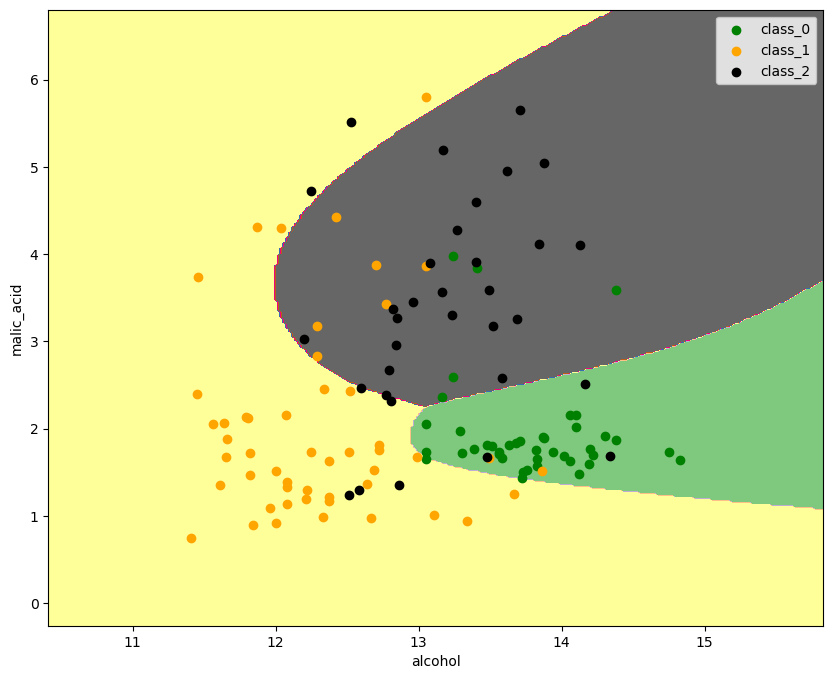

In [13]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['green', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
# наносим заливку
plt.contourf(xx, yy, preds_class, cmap='Accent')

# zip упаковывает соответствующие элементы в кортежи
for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()
    # точки -- train dataset
    # Области -- то, как нейросеть классифицирует точки в соотв. значениях
    